In [175]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx
import math
from itertools import combinations

Generazione della rete e etichettatura dei nodi
La funzione generate_block_network crea una rete a blocchi (SBM) etichettando ogni nodo con il relativo blocco, in linea con l’approccio descritto nell’articolo di Guimerà e Sales-Pardo (2009) ​

.

Modifica della rete
La funzione modify_network esegue rimozione e aggiunta casuale di collegamenti. Anche se per simulare solo missing interactions (falsi negativi) l’ideale sarebbe rimuovere esclusivamente collegamenti, la logica qui è coerente se si vuole simulare una rete “osservata” con errori misti.

In [176]:
# Function to create a simple block network  NEW
def generate_block_network(block_sizes, prob_matrix):
    """
    Genera una rete basata su un modello a blocchi stocastici (SBM).
    
    :param block_sizes: Lista che specifica il numero di nodi per ciascun blocco.
    :param prob_matrix: Matrice quadrata NxN con le probabilità di connessione tra i blocchi.
    :return: Un oggetto Graph di NetworkX.
    """
    num_blocks = len(block_sizes)
    num_nodes = sum(block_sizes)
    G = nx.Graph()
    
    # Creazione dei nodi con etichetta di blocco
    node_labels = []
    current_label = 0
    for i, size in enumerate(block_sizes):
        for _ in range(size):
            G.add_node(current_label, block=i)
            node_labels.append(current_label)
            current_label += 1
    
    # Aggiunta degli archi basati sulla probabilità nella matrice di adiacenza
    start_idx = 0
    for i in range(num_blocks):
        end_idx = start_idx + block_sizes[i]
        start_jdx = 0
        for j in range(num_blocks):
            end_jdx = start_jdx + block_sizes[j]
            
            for u in range(start_idx, end_idx):
                for v in range(start_jdx, end_jdx):
                    if u < v and np.random.rand() < prob_matrix[i][j]:
                        G.add_edge(u, v)
            
            start_jdx = end_jdx
        start_idx = end_idx
    
    return G

def get_adjacency_matrix(G):        # NEW
    """Calcola la matrice di adiacenza della rete G."""
    return nx.to_numpy_array(G)

def modify_network(G, modification_fraction):
    """Rimuove e aggiunge casualmente una frazione di collegamenti nella rete G."""
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    removed_edges = []
    added_edges = []
    
    # Rimuovi collegamenti casuali
    edges_to_remove = np.random.choice(len(edges), num_to_modify // 2, replace=False)
    for idx in edges_to_remove:
        removed_edges.append(edges[idx])
        G_modified.remove_edge(*edges[idx])
    
    # Aggiungi collegamenti casuali
    for _ in range(num_to_modify // 2):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v):
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges

def plot_modified_network(G, removed_edges, added_edges, title):
    """Plotta la rete osservata con rimozioni e aggiunte evidenziate."""
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray') # node_color=[G.nodes[n]['block']for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=2)
    #plt.title("Rete Osservata con Link Rimossi (rosso tratteggiato) e Aggiunti (verde)")
    plt.title(title)
    plt.show()

Campionamento MCMC e stima delle link reliability
Le funzioni metropolis_MCMC, calculate_H ed estimate_link_reliability seguono il formalismo bayesiano presentato nell’articolo, campionando le partizioni e valutando la probabilità dei collegamenti in modo coerente con la metodologia esposta nell’articolo

In [177]:
def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    num_nodes = len(G.nodes())
    return {node: random.choice(range(num_nodes)) for node in G.nodes()}  # Randomly assign each node to a group
    #return {node: node for node in G.nodes()}  # Every node is its own group initially

def calculate_H(P, G):
    """Calcola H(P) per una data partizione P e il grafo G."""
    # Raggruppa i nodi per blocco
    block_nodes = {}
    for node, group in P.items():
        block_nodes.setdefault(group, []).append(node)

    lO = {}  # Observed links between blocks
    r = {}   # Possible links between blocks
    
    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1
    
    # Compute rαβ (max possible links between groups)
    groups = list(block_nodes.keys())
    for g in groups:
        n = len(block_nodes[g])
        r[(g, g)] = n * (n - 1) // 2  # combinazioni di 2
    # Coppie di gruppi differenti
    for g1, g2 in combinations(groups, 2):
        r[tuple(sorted([g1, g2]))] = len(block_nodes[g1]) * len(block_nodes[g2])
    
    # Compute H(P)
    H = 0.0
    for key in r:
        # Nota: aggiungiamo 1 al denominatore come da formula e usiamo log(comb) per il termine combinatorio.
        H += math.log(r[key] + 1)
        # Per evitare log(0) o errori, usiamo 0 se non ci sono link osservati
        links = lO.get(key, 0)
        try:
            comb_value = math.comb(r[key], links) if r[key] >= links else 1
        except ValueError:
            comb_value = 1
        # Per sicurezza, se comb_value risulta 0, aggiungiamo un epsilon
        H += math.log(comb_value + 1e-10)
    
    return H
    

def metropolis_MCMC(G, num_samples= 10000, equilibration= 500):
    """Esegue il campionamento MCMC per esplorare lo spazio delle partizioni."""
    num_nodes = len(G.nodes())
    P = initialize_partition(G)  # Initial partition
    partitions = []
    
    # Equilibrazione (scarti iniziali)
    for _ in range(equilibration):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        new_group = random.choice(range(num_nodes))
        old_H = calculate_H(P, G)
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if delta_H > 0 and np.random.rand() >= np.exp(-delta_H):
            P[node] = old_group  # ripristina se mossa rifiutata
        
        # Campionamento delle partizioni
    for _ in range(num_samples):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        new_group = random.choice(range(num_nodes))
        
        old_H = calculate_H(P, G)
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        
        if delta_H > 0 and np.random.rand() >= np.exp(-delta_H):
            P[node] = old_group  # ripristina se mossa rifiutata
        
        # Salva una copia della partizione corrente
        partitions.append(P.copy())
    
    return partitions
    

def estimate_link_reliability(G, partitions):
    """
    Stima la link reliability RL_ij per ogni coppia (i,j) con i < j
    secondo la formula:
    
    RL_ij = (1/Z) * sum_{P in partitions} [ (lO_{σ_iσ_j}+1)/(r_{σ_iσ_j}+2) * exp(-H(P) ) ]
    """
    # Inizializza dizionario per RL per tutte le coppie (i,j)
    nodes = list(G.nodes())
    reliability = {}
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            reliability[(i, j)] = 0.0

    Z = 0.0  # normalizzatore
    
    for P in partitions:
        weight = np.exp(-calculate_H(P, G))
        Z += weight
        
        # Raggruppa nodi per blocco per la partizione P
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        
        # Pre-calcola r e lO per ogni coppia di blocchi per la partizione P
        r = {}
        lO = {}
        groups = list(block_nodes.keys())
        # Per i blocchi identici
        for g in groups:
            n = len(block_nodes[g])
            r[(g, g)] = n * (n - 1) // 2
            # Conta i link osservati all'interno del blocco
            count = 0
            for u, v in combinations(block_nodes[g], 2):
                if G.has_edge(u, v):
                    count += 1
            lO[(g, g)] = count
        # Per coppie di blocchi differenti
        for g1, g2 in combinations(groups, 2):
            key = tuple(sorted([g1, g2]))
            r[key] = len(block_nodes[g1]) * len(block_nodes[g2])
            count = 0
            for u in block_nodes[g1]:
                for v in block_nodes[g2]:
                    if G.has_edge(u, v):
                        count += 1
            lO[key] = count
        
        # Per ogni coppia di nodi (i, j), applica la formula in base ai gruppi di P
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                g_i = P[nodes[i]]
                g_j = P[nodes[j]]
                key = tuple(sorted([g_i, g_j]))
                # Se il blocco non ha archi osservati, lO restituisce 0
                current_lO = lO.get(key, 0)
                current_r = r.get(key, 1)  # evitiamo divisioni per zero
                reliability[(nodes[i], nodes[j])] += ((current_lO + 1) / (current_r + 2)) * weight

    # Normalizzazione
    for key in reliability:
        reliability[key] /= Z
    
    return reliability

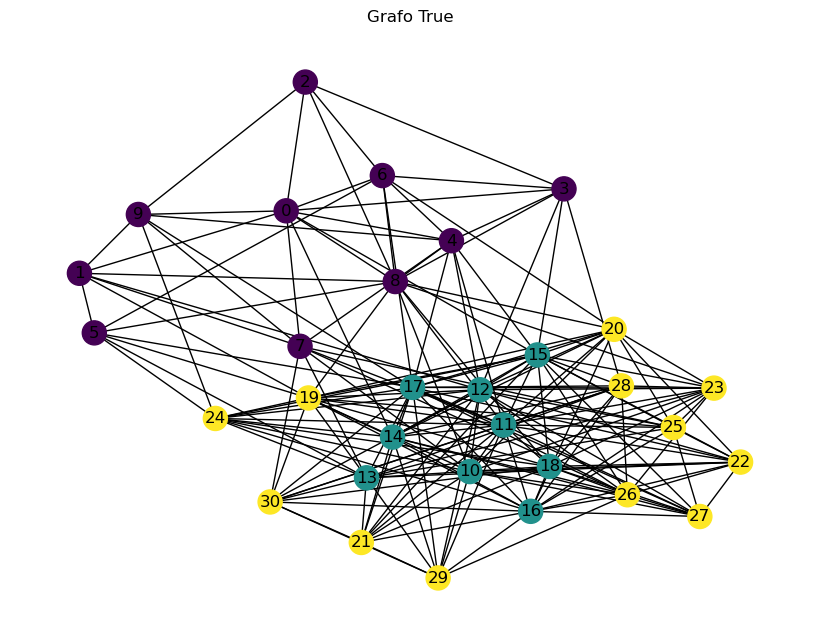

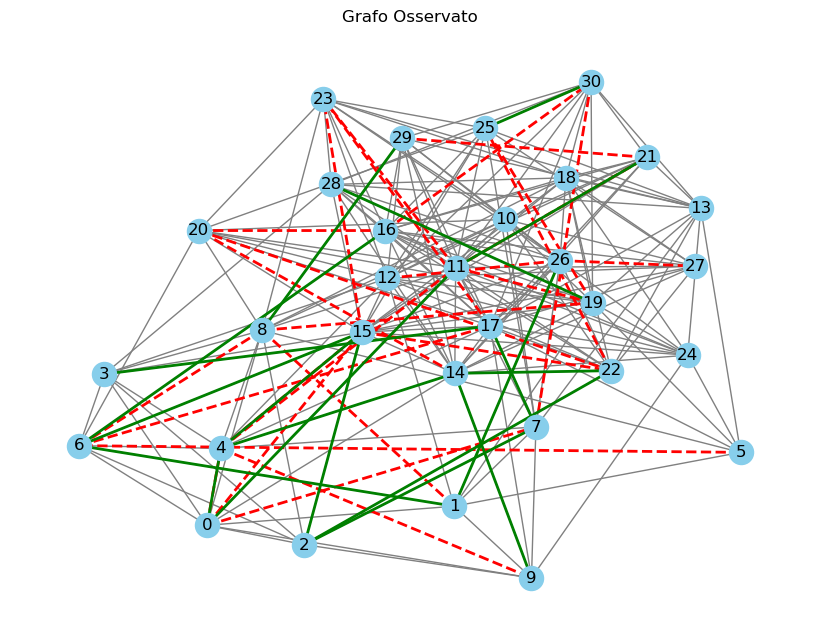

Link Reliability per alcune coppie di nodi:
Coppia (0, 1): RL = 0.5234
Coppia (0, 2): RL = 0.7612
Coppia (0, 3): RL = 0.7581
Coppia (0, 4): RL = 0.6874
Coppia (0, 5): RL = 0.2663
Coppia (0, 6): RL = 0.7685
Coppia (0, 7): RL = 0.3377
Coppia (0, 8): RL = 0.6863
Coppia (0, 9): RL = 0.5153
Coppia (0, 10): RL = 0.1656
Coppia (0, 11): RL = 0.3233
Coppia (0, 12): RL = 0.3352
Coppia (0, 13): RL = 0.1613
Coppia (0, 14): RL = 0.4233
Coppia (0, 15): RL = 0.5773
Coppia (0, 16): RL = 0.2336
Coppia (0, 17): RL = 0.3888
Coppia (0, 18): RL = 0.1627
Coppia (0, 19): RL = 0.1368
Coppia (0, 20): RL = 0.2476
Coppia (0, 21): RL = 0.0989
Coppia (0, 22): RL = 0.0983
Coppia (0, 23): RL = 0.1396
Coppia (0, 24): RL = 0.0989
Coppia (0, 25): RL = 0.1449
Coppia (0, 26): RL = 0.1958
Coppia (0, 27): RL = 0.0989
Coppia (0, 28): RL = 0.2130
Coppia (0, 29): RL = 0.0929
Coppia (0, 30): RL = 0.1266
Coppia (1, 2): RL = 0.4454
Coppia (1, 3): RL = 0.4277
Coppia (1, 4): RL = 0.4038
Coppia (1, 5): RL = 0.6215
Coppia (1, 6): RL

In [178]:

# Creiamo una rete con un modello a blocchi semplice
block_sizes = [10, 9, 12]
prob_matrix = [[0.6, 0.2, 0.1],
                [0.2, 0.5, 0.8],
                [0.1, 0.8, 0.3]]
# Genera il grafo "true" usando il modello a blocchi
G_true = generate_block_network(block_sizes, prob_matrix)
# Plotta il grafo "true"
pos_true = nx.spring_layout(G_true)
plt.figure(figsize=(8, 6))
nx.draw(G_true, pos_true, with_labels=True, node_color=[G_true.nodes[n]['block'] for n in G_true.nodes()], edge_color='black')
plt.title("Grafo True")
plt.show()


# Crea una rete osservata modificando casualmente il grafo true
modification_fraction = 0.3  # ad esempio, modifica il 10% dei collegamenti
G_obs, removed_edges, added_edges = modify_network(G_true, modification_fraction)
    
# Plotta il grafo osservato con evidenziazione dei cambiamenti
plot_modified_network(G_obs, removed_edges, added_edges, title="Grafo Osservato")
    
# Esegue il campionamento MCMC sulle partizioni della rete osservata
partitions = metropolis_MCMC(G_obs, num_samples=10000, equilibration=500)

# Stima la link reliability per ogni coppia di nodi sulla rete osservata
RL = estimate_link_reliability(G_obs, partitions)
    
# Stampa alcuni risultati (ad esempio per le prime 10 coppie)
print("Link Reliability per alcune coppie di nodi:")
for i, key in enumerate(RL):
    #if i >= 30:
        #break
    print(f"Coppia {key}: RL = {RL[key]:.4f}")




Obiettivo

    Missing Interactions (False Negatives):

        Consideriamo tutte le coppie (i,j)(i,j) per cui il collegamento vera esiste in ATAT​ (grafo true), ma non è stato osservato in AOAO​ (grafo osservato). Queste sono i falsi negativi.

        Separatamente, consideriamo le coppie (i,j)(i,j) per cui non esiste il collegamento in ATAT​ (veri negativi), e che in AOAO​ risultano anch'esse assenti.

        Ordinando in ordine decrescente le stime di link reliability RLijRLij​, si calcola la probabilità che un falso negativo abbia un valore RLRL più alto (cioè, venga classificato prima) rispetto a un vero negativo.

    Spurious Interactions (False Positives):

        Consideriamo le coppie (i,j)(i,j) per cui il collegamento non esiste in ATAT​ (vero negativo), ma in AOAO​ è presente (falso positivo).

        In parallelo, consideriamo le coppie (i,j)(i,j) in cui il collegamento esiste in entrambi i grafi (veri positivi).

        Ordinando in ordine decrescente i RLijRLij​, calcoliamo la probabilità che un falso positivo abbia un RLRL più basso (cioè, venga classificato dopo) rispetto a un vero positivo.

Queste misure sono molto simili all’area sotto la curva (AUC) in un’analisi ROC. In sostanza, per ciascuna delle due situazioni, si considerano tutte le coppie formate da un esempio "positivo" (cioè, il caso in cui il collegamento è “vero”, anche se non osservato nel primo caso, o è osservato e vero nel secondo) e uno "negativo", e si calcola la frazione delle coppie in cui il modello classifica correttamente il caso “positivo” con un punteggio maggiore (oppure, per il secondo caso, con un punteggio maggiore rispetto al falso).

Nel confronto avviene un'analisi "pairwise" (a coppie) tra le RL dei nodi in due categorie: falsi negativi e veri negativi (per le missing interactions) oppure falsi positivi e veri positivi (per le spurious interactions). Vediamo nel dettaglio come funziona per i falsi negativi:  
**Missing Interactions**

Definizione delle categorie:

- Falso negativo: Coppia (i,j) per cui nel grafo osservato AO non c'è un collegamento (AO[i,j] = 0), mentre nel grafo "true" AT c'è (AT[i,j] = 1).

- Vero negativo: Coppia (i,j) per cui in AO non c'è un collegamento (AO[i,j] = 0) e nemmeno in AT (AT[i,j] = 0).

Raccolta dei valori RL:
    Nel codice, per ogni coppia (i,j) (con i < j) vengono controllate queste condizioni. Se la coppia è classificata come falso negativo, si aggiunge il valore di RL corrispondente a una lista dei falsi negativi; se è vero negativo, il valore viene aggiunto a un’altra lista.

Confronto pairwise:
    Una volta ottenute le due liste (una per i falsi negativi e una per i veri negativi), il codice confronta ogni valore RL del falso negativo con ogni valore RL del vero negativo.

        Se il valore RL del falso negativo è maggiore di quello del vero negativo, si incrementa un contatore di 1 (questo significa che, in un ordinamento decrescente, il falso negativo verrebbe prima del vero negativo).

        Se i due valori RL sono uguali, il contatore viene incrementato di 0.5, poiché si considera un caso di parità.

        Se il valore RL del falso negativo è minore, non si incrementa il contatore.

    Calcolo della probabilità:
    Infine, si somma il numero totale di confronti effettuati (ossia, il prodotto della lunghezza delle due liste) e si divide il contatore per questo totale. Il risultato è la probabilità che, in un ordinamento decrescente, un falso negativo (cioè, un link che in realtà esiste ma è stato rimosso) abbia un valore di RL più alto rispetto a un vero negativo.

**Spurious Interactions**

Il ragionamento è simile, ma in questo caso:

- Falso positivo: Coppia (i,j) con AO[i,j] = 1 e AT[i,j] = 0.

- Vero positivo: Coppia (i,j) con AO[i,j] = 1 e AT[i,j] = 1.

Per ciascuna coppia, si confronta il valore RL del falso positivo con quello del vero positivo, ma qui l'ideale è che il falso positivo abbia un valore minore (poiché, ordinando in ordine decrescente, il vero positivo deve avere un ranking più elevato). La logica di confronto (aggiunta di 1 o 0.5 in caso di parità) e il calcolo della probabilità seguono lo stesso procedimento.
Conclusione

Anche se nel codice non viene creato esplicitamente un vettore ordinato in ordine decrescente, il confronto pairwise tra le due categorie (falsi negativi contro veri negativi o falsi positivi contro veri positivi) fornisce lo stesso tipo di informazione: cioè, quanto frequentemente l'algoritmo assegna un valore RL più favorevole a un link che in realtà esiste (o è corretto) rispetto a uno che non esiste (o è errato). Questo approccio permette di quantificare la capacità del metodo di "classificare" correttamente i link in base alla loro affidabilità, così come descritto nell'articolo.

In [179]:
def rank_probability_missing_interactions(G_true, G_obs, RL):
    """
    Calcola la probabilità che un falso negativo (AO=0, AT=1) abbia un RL
    maggiore di un vero negativo (AO=0, AT=0).
    
    G_true: grafo true (AT)
    G_obs: grafo osservato (AO)
    RL: dizionario delle link reliability per ogni coppia (i,j) con i<j.
    """
    false_negatives = []  # AO=0, AT=1
    true_negatives = []   # AO=0, AT=0
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    # Costruiamo le liste delle coppie in base alle definizioni
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 0:
                if A_true[i, j] == 1:
                    false_negatives.append(RL[(i, j)])
                else:
                    true_negatives.append(RL[(i, j)])
    
    # Se non ci sono esempi, ritorna None o 0
    if not false_negatives or not true_negatives:
        return None
    
    count = 0
    total = 0
    # Per ogni coppia, sommiamo 1 se il falso negativo ha RL > RL del vero negativo,
    # 0.5 se sono uguali.
    for fn in false_negatives:
        for tn in true_negatives:
            total += 1
            if fn > tn:
                count += 1
            elif fn == tn:
                count += 0.5
    probability = count / total
    return probability

def rank_probability_spurious_interactions(G_true, G_obs, RL):
    """
    Calcola la probabilità che un falso positivo (AO=1, AT=0) abbia un RL
    inferiore a un vero positivo (AO=1, AT=1).
    
    G_true: grafo true (AT)
    G_obs: grafo osservato (AO)
    RL: dizionario delle link reliability per ogni coppia (i,j) con i<j.
    """
    false_positives = []  # AO=1, AT=0
    true_positives = []   # AO=1, AT=1
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 1:
                if A_true[i, j] == 0:
                    false_positives.append(RL[(i, j)])
                else:
                    true_positives.append(RL[(i, j)])
    
    if not false_positives or not true_positives:
        return None
    
    count = 0
    total = 0
    # Ora vogliamo che il falso positivo abbia RL inferiore rispetto al vero positivo,
    # cioè, in un ordinamento decrescente il vero positivo deve venire prima.
    for fp in false_positives:
        for tp in true_positives:
            total += 1
            if fp < tp:
                count += 1
            elif fp == tp:
                count += 0.5
    probability = count / total
    return probability



Funzioni per il ranking di missing e spurious interactions
Le funzioni rank_probability_missing_interactions e rank_probability_spurious_interactions calcolano rispettivamente la probabilità che un falso negativo (o positivo) abbia un ranking migliore rispetto a un vero negativo (o positivo). La logica è in linea con quanto riportato nell’articolo per quantificare le performance del metodo.

In [180]:
# Calcola la probabilità per missing interactions (falsi negativi)
p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
if p_missing is not None:
    print(f"Probabilità che un falso negativo abbia un RL più alto di un vero negativo: {p_missing:.4f}")
else:
    print("Non ci sono abbastanza esempi per missing interactions.")
    
# Calcola la probabilità per spurious interactions (falsi positivi)
p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
if p_spurious is not None:
    print(f"Probabilità che un falso positivo abbia un RL più basso di un vero positivo: {p_spurious:.4f}")
else:
    print("Non ci sono abbastanza esempi per spurious interactions.")

Probabilità che un falso negativo abbia un RL più alto di un vero negativo: 0.7603
Probabilità che un falso positivo abbia un RL più basso di un vero positivo: 0.7867


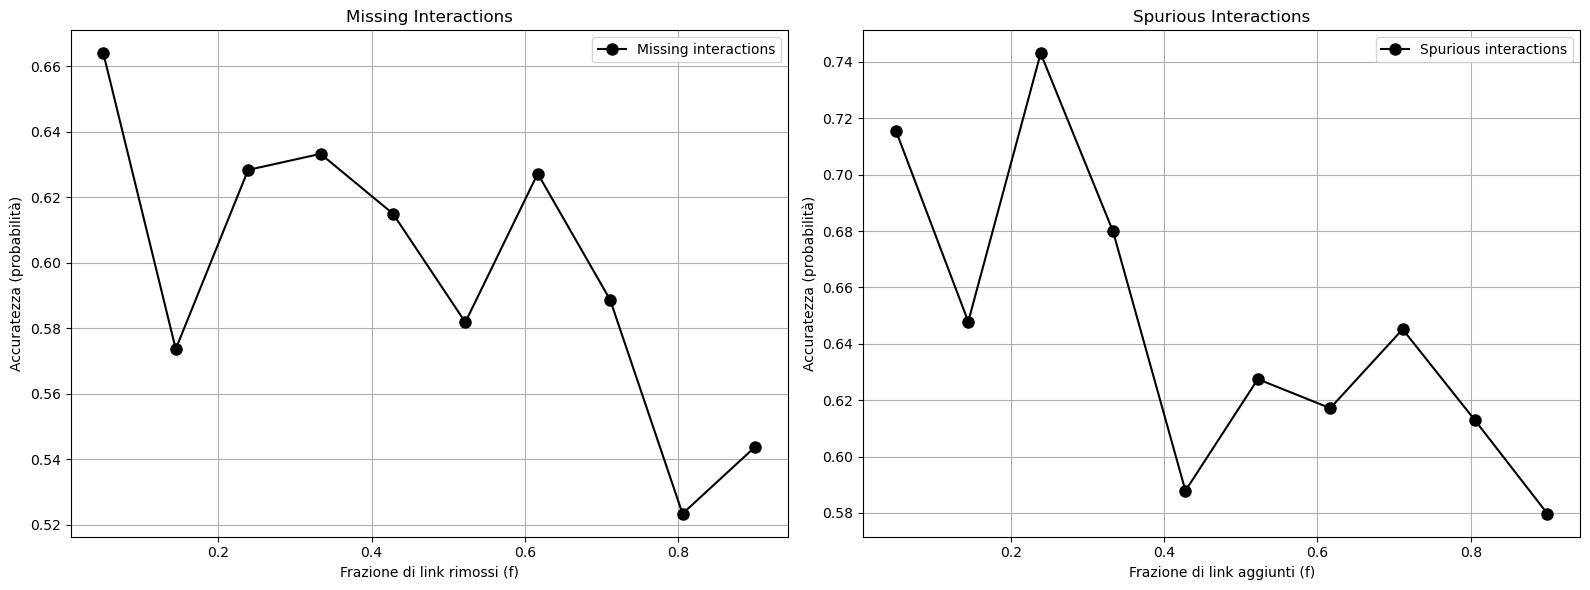

In [181]:
# GRAFICI NERI UGUALI A FIGURA 2 ARTICOLO

def calculate_accuracies(G_true, error_fractions, num_samples=1000, equilibration=100):
    """
    Calcola le accuracy per le Missing e Spurious Interactions.

    Args:
        G_true: La rete "vera" originale.
        error_fractions: Lista di frazioni di errori da testare.
        num_samples: Numero di campioni per il campionamento MCMC.
        equilibration: Numero di iterazioni per la fase di equilibrio.

    Returns:
        accuracy_missing: Lista di accuracy per le missing interactions.
        accuracy_spurious: Lista di accuracy per le spurious interactions.
    """
    accuracy_missing = []
    accuracy_spurious = []

    # --- Missing Interactions ---
    for f in error_fractions:
        G_obs_missing = G_true.copy()
        edges = list(G_true.edges())
        num_remove = int(len(edges) * f)

        if num_remove == 0:  # Caso speciale
            accuracy_missing.append(1.0)
            continue

        remove_indices = np.random.choice(len(edges), num_remove, replace=False)
        for idx in remove_indices:
            G_obs_missing.remove_edge(*edges[idx])

        partitions_missing = metropolis_MCMC(G_obs_missing, num_samples, equilibration)
        RL_missing = estimate_link_reliability(G_obs_missing, partitions_missing)
        p_missing = rank_probability_missing_interactions(G_true, G_obs_missing, RL_missing)

        if p_missing is None:  # Caso con nessun falso negativo o veri negativi
            accuracy_missing.append(1.0)
        else:
            accuracy_missing.append(p_missing)

    # --- Spurious Interactions ---
    for f in error_fractions:
        G_obs_spurious = G_true.copy()
        non_edges = list(nx.non_edges(G_true))
        num_to_add = int(len(G_true.edges()) * f)

        if num_to_add == 0:  # Caso speciale
            accuracy_spurious.append(1.0)
            continue

        add_indices = np.random.choice(len(non_edges), num_to_add, replace=False)
        for idx in add_indices:
            G_obs_spurious.add_edge(*non_edges[idx])

        partitions_spurious = metropolis_MCMC(G_obs_spurious, num_samples, equilibration)
        RL_spurious = estimate_link_reliability(G_obs_spurious, partitions_spurious)
        p_spurious = rank_probability_spurious_interactions(G_true, G_obs_spurious, RL_spurious)

        if p_spurious is None:  # Caso con nessun falso positivo o veri negativi
            accuracy_spurious.append(1.0)
        else:
            accuracy_spurious.append(p_spurious)

    return accuracy_missing, accuracy_spurious


# Calcolo delle accuracies
error_fractions = np.linspace(0.05, 0.9, 10)
accuracy_missing, accuracy_spurious = calculate_accuracies(G_true, error_fractions)

# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Grafico per Missing Interactions
ax1.plot(error_fractions, accuracy_missing, 'ko-', markersize=8, label='Missing interactions')
ax1.set_xlabel('Frazione di link rimossi (f)')
ax1.set_ylabel('Accuratezza (probabilità)')
ax1.set_title('Missing Interactions')
ax1.legend()
ax1.grid(True)

# Grafico per Spurious Interactions
ax2.plot(error_fractions, accuracy_spurious, 'ko-', markersize=8, label='Spurious interactions')
ax2.set_xlabel('Frazione di link aggiunti (f)')
ax2.set_ylabel('Accuratezza (probabilità)')
ax2.set_title('Spurious Interactions')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()